# DP1 delivered image quality

Taken from SITCOMTN-149 and applied to DP1 data with pulication customisations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

from lsst.daf.butler import Butler
import lsst.geom

# Set a standard figure size to use
from lsst.utils.plotting import publication_plots
from lsst.utils.plotting import get_multiband_plot_colors, get_multiband_plot_symbols, get_multiband_plot_linestyles

In [2]:
instrument = 'LSSTComCam'
collections = ['LSSTComCam/raw/all', 
               'LSSTComCam/DP1/defaults', 
               'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260' ]
skymap = 'lsst_cells_v1'
butler = Butler("/repo/dp1",
                instrument=instrument, 
                collections=collections, 
                skymap=skymap)

In [3]:
# Applying the Rubin DP1 paper custom style sheet to all of the graphs to be created in this notebook
publication_plots.set_rubin_plotstyle()
bands_dict = publication_plots.get_band_dicts()
colors = get_multiband_plot_colors()
bands = colors.keys()  # important to get the right order for plot legends
%matplotlib inline

Set up Rubin matplotlib plot style.
This includes dicts for colors (bandpass colors for white background),
  colors_black (bandpass colors for black background), symbols, and line_styles,
  keyed on band (ugrizy).


In [15]:
visit_detector_table = butler.get("visit_detector_table", storageClass="DataFrame")

In [5]:
# Extract and format data for analysis
df = visit_detector_table[['detectorId','visitId', 'band', 'psfSigma','seeing']].copy()
df["psfFwhm"]=df["psfSigma"]*2.355*0.2
df

,detectorId,visitId,band,psfSigma,seeing,psfFwhm
0,0,2024110800245,i,1.832573,0.864554,0.863142
1,1,2024110800245,i,1.746872,0.823865,0.822776
2,2,2024110800245,i,1.789050,0.844020,0.842643
3,3,2024110800245,i,1.822840,0.859669,0.858558
4,4,2024110800245,i,1.713867,0.808050,0.807231
...,...,...,...,...,...,...
16066,4,2024121100611,r,1.650342,0.778259,0.777311
16067,5,2024121100611,r,1.649252,0.777973,0.776798
16068,6,2024121100611,r,1.622512,0.765628,0.764203
16069,7,2024121100611,r,1.640941,0.774048,0.772883


In [6]:
# Best delivered IQ
min_row = df.loc[df['psfFwhm'].idxmin()]
min_row

detectorId                7
visitId       2024112400119
band                      i
psfSigma           0.288675
seeing             0.136147
psfFwhm            0.135966
Name: 3643, dtype: object

In [16]:
# This is very low -- 0.135 arcsec seeing is not physical.
# Should these and other such visits be excluded from the dataset?
rows = df[df['visitId'] == 2024112400119]
rows

,detectorId,visitId,band,psfSigma,seeing,psfFwhm
3636,0,2024112400119,i,2.357925,1.112520,1.110583
3637,1,2024112400119,i,2.344967,1.106029,1.104479
3638,2,2024112400119,i,2.326107,1.097483,1.095596
3639,3,2024112400119,i,2.380226,1.122648,1.121087
3640,4,2024112400119,i,2.380704,1.122506,1.121312
3641,5,2024112400119,i,2.323589,1.095907,1.094410
3642,6,2024112400119,i,2.521431,1.189638,1.187594
3643,7,2024112400119,i,0.288675,0.136147,0.135966
3644,8,2024112400119,i,2.675308,1.262324,1.260070


In [20]:
# Compute and export out the IQ table percentile data
percentiles = [25, 50, 75]
iq_pctls = df.groupby('band')['psfFwhm'].quantile([p / 100 for p in percentiles]).apply(lambda x: round(x, 2)).unstack()

# Sort according to standard band order
iq_pctls.index = pd.Categorical(iq_pctls.index, categories=bands, ordered=True)
iq_pctls

,0.25,0.50,0.75
g,1.07,1.17,1.29
i,0.92,1.03,1.13
r,0.99,1.12,1.22
u,1.34,1.48,1.67
y,0.94,1.01,1.10
z,0.98,1.11,1.21


In [21]:
# Write to table for inclusion in latex table 
iq_pctls.to_csv('../tables/iq_data.csv', index=False)

In [22]:
# Extract data from visit table for plotting
data = {}
for band in bands:
    data[band] = np.array(df[df['band'].str.contains(band)]['psfFwhm']) 

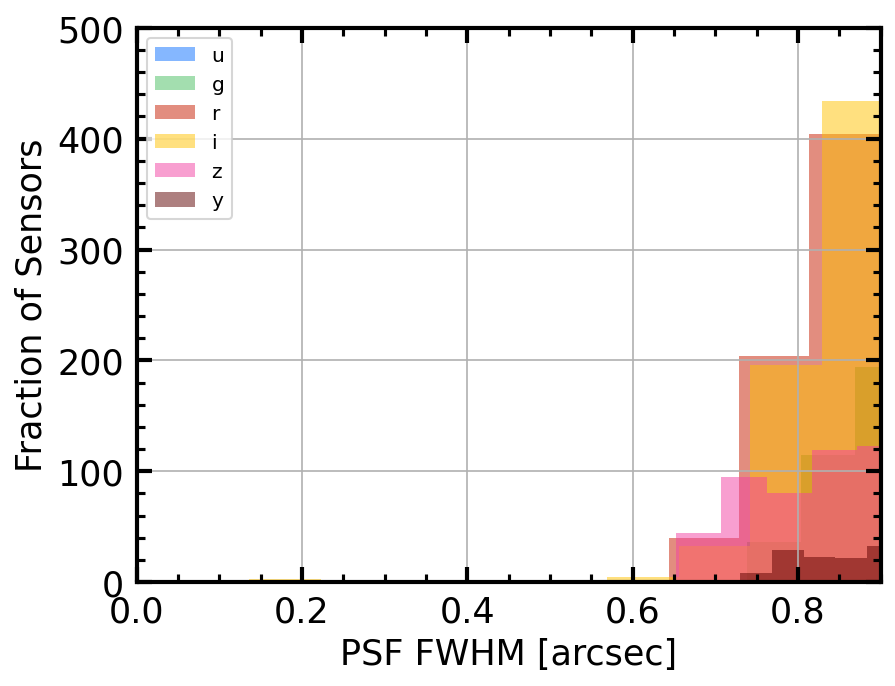

In [25]:
# IQ histogram - not for inclusion in the paper but interesting
plt.figure()

for label, d in data.items():
    plt.hist(d, bins=20, alpha=0.5,
             linestyle='-',
             color = colors[label],
             label=label)

# Customize plot
plt.xlabel('PSF FWHM [arcsec]')
plt.ylabel('Fraction of Sensors')
plt.grid(True)
plt.legend()
plt.xlim(0, 0.9)  
plt.ylim(0, 500) 

plt.savefig("../figures/image_quality_histo.png", 
            bbox_inches='tight',  # Trim whitespace around the figure
            transparent=True,     # Transparent background
            format='png')         # Explicit format specification
plt.show()

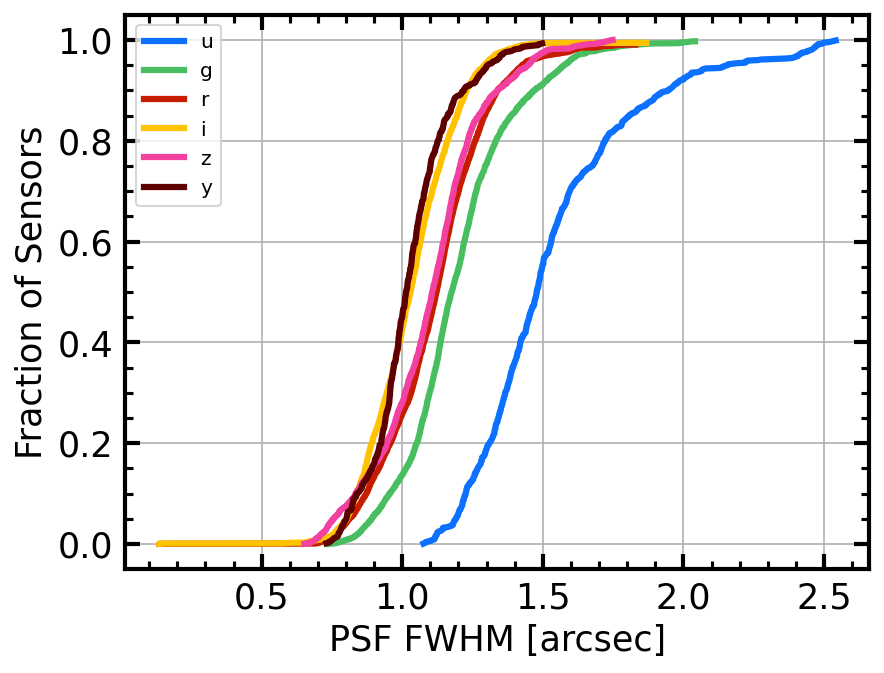

In [24]:
# IQ ECDF --  long tail in the i-band
plt.figure()

for label, d in data.items():
    ecdf = ECDF(d)
    plt.plot(ecdf.x, ecdf.y, 
             linestyle='-',
             color = colors[label],
             label=label)

# Customize plot
plt.xlabel('PSF FWHM [arcsec]')
plt.ylabel('Fraction of Sensors')
plt.grid(True)
plt.legend()
plt.savefig("../figures/image_quality_histo.png", 
            bbox_inches='tight',  # Trim whitespace around the figure
            transparent=True,     # Transparent background
            format='png')         # Explicit format specification
plt.show()

In [13]:
# Investigate the variation by field

In [14]:
plt.close()